<a href="https://colab.research.google.com/github/J0SAL/IMDB-Dataset-of-50K-Movie-Reviews/blob/main/Fellowship_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras sklearn

In [ ]:
!pip install tensorflow

In [ ]:
!pip install tensorflow-gpu

In [ ]:
!pip install Keras-Preprocessing

In [42]:
# Unique words
VOC_SIZE = 50000

# Sentence Len
SEN_LEN = 1500

# Vector Size for each word
EMBED_DIM=300

# Test & Train size
TEST_SIZE = 0.3
EPOCHS = 5
BATCH_SIZE = 100

In [8]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/"
DATA_DIR = BASE_DIR+'Datasets/'
MODEL_DIR = BASE_DIR+'Models/'

In [9]:
import tensorflow as tf
import tensorflow

In [10]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.initializers import Constant
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pickle
import gensim

### Read data

In [12]:
dir = DATA_DIR + 'IMDB Dataset.csv'
data = pd.read_csv(dir)

In [13]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [14]:
data.sentiment.unique()

array(['positive', 'negative'], dtype=object)

In [15]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [16]:
data.shape

(50000, 2)

In [17]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [18]:
sentiment = []
for l in data.sentiment:
    if l == "positive":
        sentiment.append(1)
    elif l == "negative":
        sentiment.append(0)

In [19]:
data['sentiment']= sentiment

In [20]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


<Axes: xlabel='sentiment', ylabel='count'>

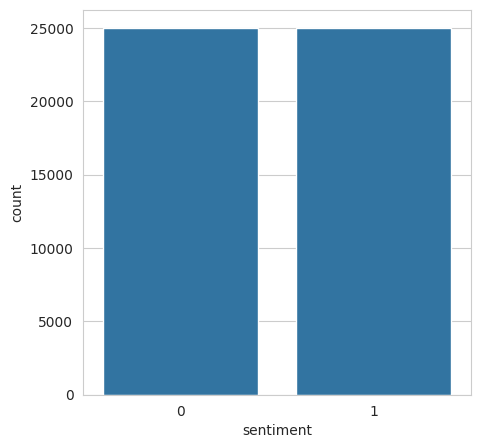

In [21]:
#checking if the dataset is balanced
sns.set_style('whitegrid')
plt.figure(figsize=(5,5))
sns.countplot(x='sentiment',data=data)

### Get Independent and Dependent features

In [22]:
X=data.drop('sentiment',axis=1)
y=data.drop('review', axis=1)

In [23]:
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Data Preprocessing

In [26]:
messages = X.copy()

In [27]:
### Dataset Preprocessing
from nltk.stem import WordNetLemmatizer #lemmatization purpose
lemmatizer=WordNetLemmatizer()

corpus = []
for i in range(0, len(messages)):
    review = re.sub("[^a-zA-Z]", " ", messages['review'][i])
    review = review.lower()
    review = review.split()

    review = [lemmatizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

### Word to Vec

#### Generate Your Own Word to Vec

In [28]:
def generate_word2vec_tokens(list_of_sentences):
  sentences = []
  for s in list_of_sentences:
    sentences.append(s.split())
  return sentences

def generate_word2vec(sentences):
  w2v_model=gensim.models.Word2Vec(sentences=sentences,vector_size=300,window=10,min_count=1)
  w2v_model.train(sentences,epochs=10,total_examples=len(sentences))
  return w2v_model

def save_word2vec(word2vec_model, model_name):
  word2vec_model.wv.save_word2vec_format(MODEL_DIR+model_name, binary=True)

def load_word2vec(model_name):
  loaded_model = gensim.models.KeyedVectors.load_word2vec_format(MODEL_DIR+model_name, binary=True)
  return loaded_model

In [29]:
# ss = generate_word2vec_tokens(corpus)
# word2vec_model = generate_word2vec(ss)
# save_word2vec(word2vec_model, 'word2vec/word2vec.bin')

#### Load Word2Vec

In [30]:
w2v_model = load_word2vec('word2vec/word2vec.bin')

### Tokenization, Padding and Embeddings

In [31]:
def apply_tokenizer(data):
  tok = Tokenizer(num_words = VOC_SIZE)
  tok.fit_on_texts(data)
  encoded_data = tok.texts_to_sequences(data)
  return [tok, encoded_data]

def apply_padding(data):
  pad_data = pad_sequences(data, maxlen=SEN_LEN)
  print("New Dimensions: ", pad_data.shape)
  return pad_data

def generate_embedded_matrix(tok, w2v_model):
  embed_matrix=np.zeros(shape=(VOC_SIZE,EMBED_DIM))
  for word,i in tok.word_index.items():
    if i < VOC_SIZE:
      embed_vector=w2v_model.get_vector(word)
      if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
        embed_matrix[i]=embed_vector
  return embed_matrix

In [32]:
tok, encoded_corpus = apply_tokenizer(corpus)

In [33]:
pad_corpus = apply_padding(encoded_corpus)

New Dimensions:  (50000, 1500)


In [34]:
embed_matrix = generate_embedded_matrix(tok, w2v_model)

### Generating Train and Test data

In [35]:
import numpy as np
X_final=pad_corpus
y_final= np.array(y)

In [36]:
X_final.shape,y_final.shape

((50000, 1500), (50000, 1))

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=TEST_SIZE, random_state=42)

### Training The Model

In [38]:
acc = []
models = []

In [39]:
# Create Model
def create_model(MODEL):
  model=Sequential()
  model.add(Embedding(input_dim=VOC_SIZE,output_dim=EMBED_DIM,input_length=SEN_LEN,embeddings_initializer=Constant(embed_matrix)))
  model.add(Dense(256))
  model.add(Dropout(0.05))
  model.add(MODEL)
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()
  return model

# Train Model
def train_model(MODEL, x_train, y_train):
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
  # callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.0025)
  MODEL.fit(
      x_train,
      y_train,
      validation_split=0.1,
      epochs=EPOCHS,
      shuffle=True,
      batch_size=BATCH_SIZE
      ,callbacks=[earlystop]
  )

def generate_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test,y_pred)

  ax = plt.subplot()
  sns.set(font_scale=3.0) # Adjust to fit
  sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");

  label_font = {'size':'18'}  # Adjust to fit
  ax.set_xlabel('Predicted labels', fontdict=label_font);
  ax.set_ylabel('True labels', fontdict=label_font);

  ax.set_title('Confusion Matrix', fontdict=label_font);

  ax.xaxis.set_ticklabels(['Real', 'Fake']);
  ax.yaxis.set_ticklabels(['Real', 'Fake']);
  plt.show()

def save_model_accuracy(model_name, accuracy):
  acc.append(accuracy)
  models.append(model_name)

def generate_classification_report(y_test, y_pred):
  print(classification_report(y_test,y_pred))

# Test Model
def test_model(MODEL, model_name, x_test, y_test):
  y_pred=MODEL.predict(x_test)
  y_pred=np.where(y_pred >= 0.5, 1,0)
  score = accuracy_score(y_pred,y_test)
  print('Model Accuracy: ',score)
  print("\n\n")
  generate_confusion_matrix(y_test, y_pred)
  print("\n\nClassification Report")
  generate_classification_report(y_test,y_pred)
  save_model_accuracy(model_name, score)

# save model
def save_model(MODEL, model_name):
  MODEL.save(MODEL_DIR+model_name)

### 1. RNN LSTM

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1500, 300)         15000000  
                                                                 
 dense_4 (Dense)             (None, 1500, 256)         77056     
                                                                 
 dropout_2 (Dropout)         (None, 1500, 256)         0         
                                                                 
 lstm_2 (LSTM)               (None, 256)               525312    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 15602625 (59.52 MB)
Trainable params: 15602625 (59.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
45

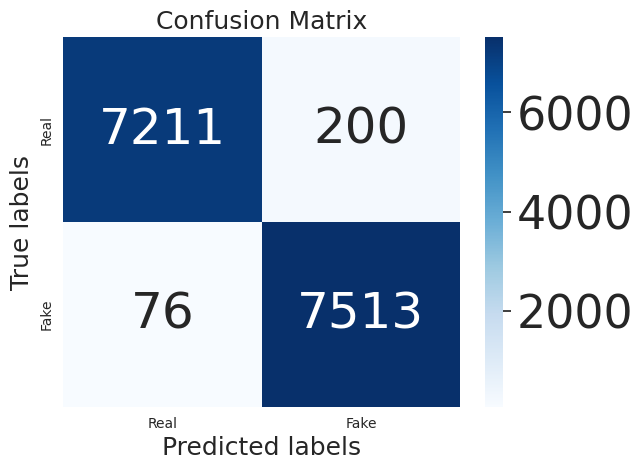



Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7411
           1       0.97      0.99      0.98      7589

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
lstm_model=create_model(LSTM(256))
train_model(lstm_model, X_final, y_final)
test_model(lstm_model,"RNN_LSTM", X_test, y_test)
save_model(lstm_model, 'word2vec/rnn_lstm.h5')

### 2. Bidirectional RNN LSTM

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1500, 300)         15000000  
                                                                 
 dense_6 (Dense)             (None, 1500, 256)         77056     
                                                                 
 dropout_3 (Dropout)         (None, 1500, 256)         0         
                                                                 
 bidirectional (Bidirection  (None, 512)               1050624   
 al)                                                             
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 16128193 (61.52 MB)
Trainable params: 16128193 (61.52 MB)
Non-trainable params: 0 (0.00 Byte)
____________

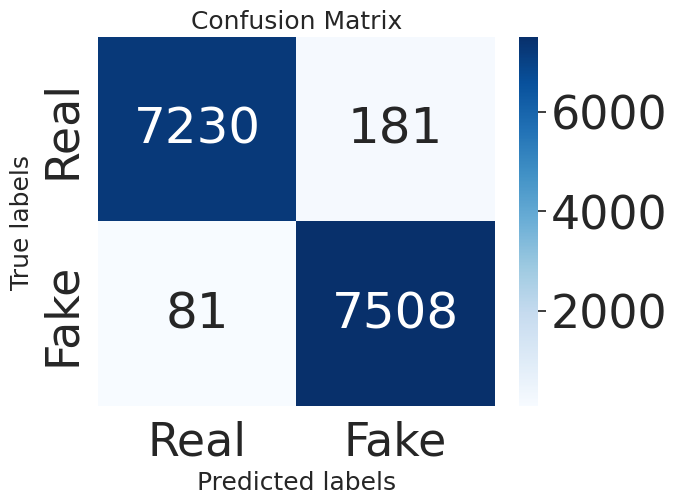



Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7411
           1       0.98      0.99      0.98      7589

    accuracy                           0.98     15000
   macro avg       0.98      0.98      0.98     15000
weighted avg       0.98      0.98      0.98     15000



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
bi_lstm = create_model(Bidirectional(LSTM(256)))
train_model(bi_lstm, X_final, y_final)
test_model(bi_lstm,"Bidirectional_LSTM_RNN", X_test, y_test)
save_model(bi_lstm, 'word2vec/bi_lstm_rnn.h5')

## Accuracy Comparision

<ipython-input-45-5f1e172b574f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = acc,y = models,palette='dark')


<Axes: title={'center': 'Accuracy Comparison'}, xlabel='Accuracy', ylabel='Algorithm'>

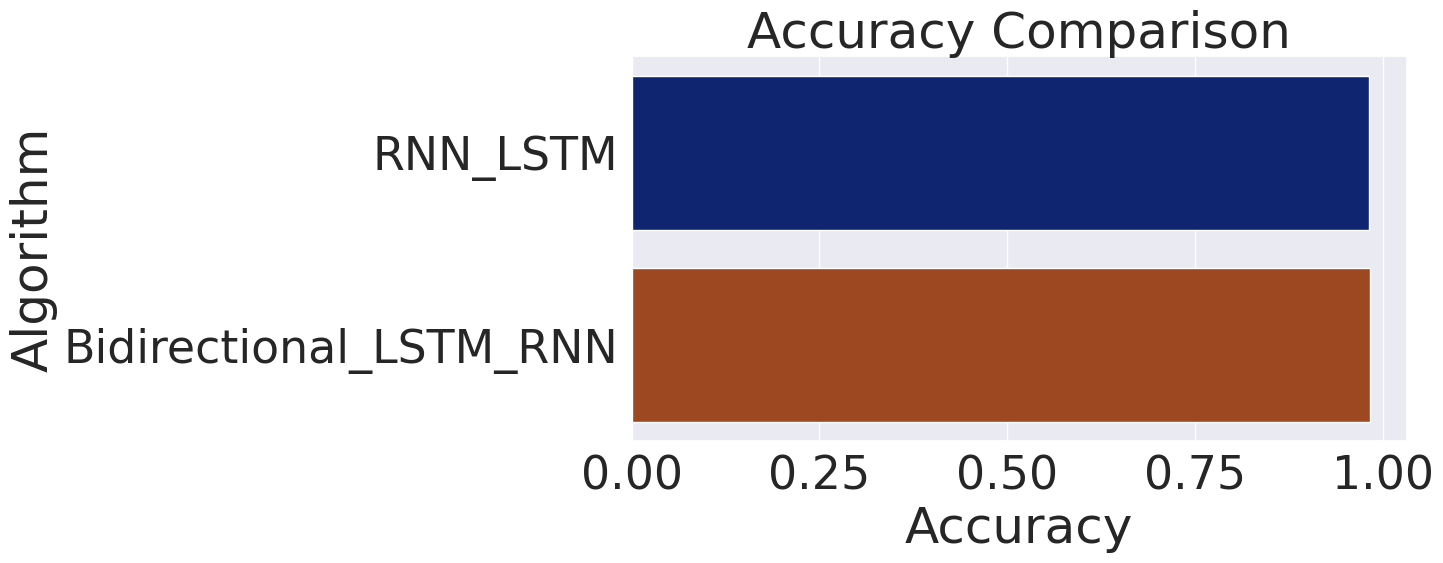

In [45]:
plt.figure(figsize=[10,5],dpi = 100)
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Algorithm')
sns.barplot(x = acc,y = models,palette='dark')